In [1]:
%load_ext rpy2.ipython

# 1 - R

In [ ]:
%%R

install.packages("remotes")
install.packages("doParallel")
install.packages("quantreg")
install.packages("memoise")
install.packages("Mcomp")
install.packages("Tcomp")
install.packages("gam")
remotes::install_github("Techtonique/ahead")
#install.packages("forecast")
library(forecast)


require(Mcomp)

accuracy <- function(obj, xx)
{
  x <- obj$mean
  f <- xx
  (mae <- mean(abs((x - f))) * 100)
  (rmse <- sqrt(mean((x - f)**2)))
  # Training data (historical observations)
  train <- obj$x               # x = training data in M3
  # Test data (true future values)
  test <- xx               # xx = test data in M3
  # Forecast horizon (h)
  h <- length(test)               # e.g., 18 for monthly M3
  # Determine seasonal period (m)
  m <- frequency(train)   # e.g., 12 for monthly data
  # Compute scaling factor (MAE of in-sample seasonal naive forecasts)
  if (m > 1) {
    scale <- mean(abs(diff(train, lag = m)))
  } else {
    scale <- mean(abs(diff(train, lag = 1)))
  }
  # MASE = mean(|test - forecast|) / scale
  mase <- mean(abs(test - obj$mean)) / max(scale, 1e-6)
  x <- c(mae, rmse, mase)
  names(x) <- c("mae", "rmse", "mase")
  return(x)
}
accuracy <- memoise::memoise(accuracy)


thetaf <- memoise::memoise(forecast::thetaf)
glmthetaf <- memoise::memoise(ahead::glmthetaf)

In [ ]:
%%R

# Load necessary libraries
library(doSNOW)
library(tcltk)

# Tcomp series -----
(nseries <- length(Tcomp::tourism))

# Set up parallel backend
cl <- makeSOCKcluster(2)  # Use 2 cores (adjust as needed)
registerDoSNOW(cl)

# Define progress bar
pb <- txtProgressBar(min = 0, max = nseries, style = 3)

# Progress function
progress <- function(n) setTxtProgressBar(pb, n)

# Options for progress tracking
opts <- list(progress = progress)

# Parallel loop with progress bar
results <- foreach(i = 1:nseries, .combine = rbind,
                   .errorhandling = "stop",
                   .options.snow = opts) %dopar% {
  x <- Tcomp::tourism[[i]]$x
  xx <- Tcomp::tourism[[i]]$xx
  h <- length(xx)

  # thetaf
  obj <- suppressWarnings(thetaf(x, h = h))
  res1 <- accuracy(obj, xx)

  # glmthetaf with MASS::glm.nb
  obj <- suppressWarnings(glmthetaf(x, h = h,
                                    fit_func = MASS::glm.nb,
                                    attention = TRUE))
  res2 <- accuracy(obj, xx)

  # glmthetaf with stats::glm
  obj <- suppressWarnings(glmthetaf(x, h = h,
                                    fit_func = stats::glm,
                                    attention = TRUE))
  res3 <- accuracy(obj, xx)

  # glmthetaf with MASS::rlm
  obj <- suppressWarnings(glmthetaf(x, h = h,
                                    fit_func = MASS::rlm,
                                    attention = TRUE))
  res4 <- accuracy(obj, xx)

  # glmthetaf with MASS::lqs
  obj <- suppressWarnings(glmthetaf(x, h = h,
                                    fit_func = MASS::lqs,
                                    attention = TRUE))
  res5 <- accuracy(obj, xx)

  # glmthetaf with gam::gam
  obj <- suppressWarnings(glmthetaf(x, h = h,
                                    fit_func = gam::gam,
                                    attention = TRUE))
  res6 <- accuracy(obj, xx)

  # glmthetaf with quantreg::rq
  obj <- suppressWarnings(glmthetaf(x, h = h,
                                    fit_func = quantreg::rq,
                                    attention = TRUE))
  res7 <- accuracy(obj, xx)

  # Determine period
  period <- switch(Tcomp::tourism[[i]]$period,
                   "YEARLY" = 1,
                   "QUARTERLY" = 4,
                   "MONTHLY" = 12)

  # Combine results
  res <- cbind(i, period,
               res1, res2,
               res3, res4,
               res5, res6, res7)
  colnames(res) <- c("series", "period", "theta", "glmnbtheta",
                     "glmtheta", "rlmtheta", "lqstheta",
                     "gamtheta", "quantregtheta")
  res
}

# Stop cluster
stopCluster(cl)

# Close progress bar
close(pb)

# Convert results to data frame
results <- data.frame(results)

In [16]:
%%R

cat("\n\n FREQ = YEARLY: \n\n")
print(summary(subset(results[grep("mase", rownames(results)), ], period==1)))
cat("\n\n FREQ = QUARTERLY: \n\n")
print(summary(subset(results[grep("mase", rownames(results)), ], period==4)))
cat("\n\n FREQ = MONTHLY: \n\n")
print(summary(subset(results[grep("mase", rownames(results)), ], period==12)))



 FREQ = YEARLY: 

     series           period      theta           glmnbtheta      
 Min.   : 794.0   Min.   :1   Min.   : 0.1659   Min.   : 0.05748  
 1st Qu.: 923.2   1st Qu.:1   1st Qu.: 1.1685   1st Qu.: 1.35561  
 Median :1052.5   Median :1   Median : 2.0720   Median : 2.37390  
 Mean   :1052.5   Mean   :1   Mean   : 2.7303   Mean   : 3.02639  
 3rd Qu.:1181.8   3rd Qu.:1   3rd Qu.: 3.4361   3rd Qu.: 4.01669  
 Max.   :1311.0   Max.   :1   Max.   :12.6591   Max.   :13.42235  
    glmtheta          rlmtheta          lqstheta          gamtheta      
 Min.   : 0.2033   Min.   : 0.2137   Min.   : 0.1668   Min.   : 0.2033  
 1st Qu.: 1.1823   1st Qu.: 1.1735   1st Qu.: 1.2370   1st Qu.: 1.1823  
 Median : 2.0801   Median : 2.0370   Median : 2.1895   Median : 2.0801  
 Mean   : 2.7299   Mean   : 2.7089   Mean   : 2.8286   Mean   : 2.7299  
 3rd Qu.: 3.4745   3rd Qu.: 3.4714   3rd Qu.: 3.8234   3rd Qu.: 3.4745  
 Max.   :12.7243   Max.   :12.2952   Max.   :14.8614   Max.   :12.7243  




 FREQ = YEARLY: 



 FREQ = QUARTERLY: 



 FREQ = MONTHLY: 



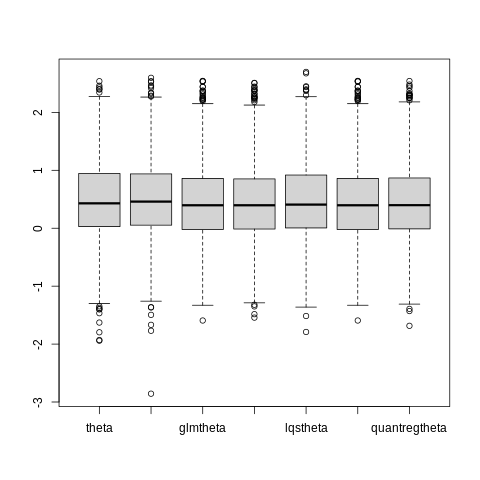

In [21]:
%%R

cat("\n\n FREQ = YEARLY: \n\n")
boxplot(log(subset(results[grep("mase", rownames(results)), -c(1, 2)])))
cat("\n\n FREQ = QUARTERLY: \n\n")
boxplot(log(subset(results[grep("mase", rownames(results)), -c(1, 2)])))
cat("\n\n FREQ = MONTHLY: \n\n")
boxplot(log(subset(results[grep("mase", rownames(results)), -c(1, 2)])))

# 2 - Python

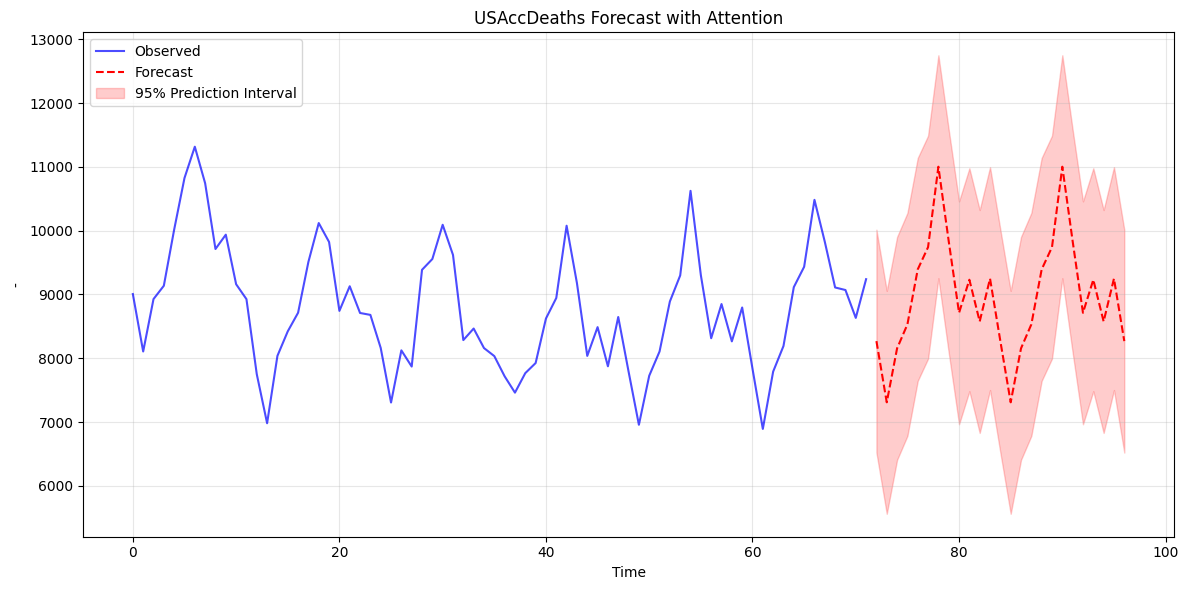

In [28]:
from rpy2.robjects.packages import importr
from rpy2.robjects import r
import rpy2.robjects as ro
import numpy as np
import matplotlib.pyplot as plt
from rpy2.robjects import pandas2ri

# Import required R packages
ahead = importr('ahead')
mass = importr('MASS')
base = importr('base')
stats = importr('stats')

# Get the data and fit the model
with localconverter(ro.default_converter):
    # Get AirPassengers data
    data = r('USAccDeaths')
    data = np.array(data)

    # Fit the model
    fit = r('''
        suppressWarnings(
            ahead::glmthetaf(
                USAccDeaths,
                h=25L,
                fit_func=MASS::glm.nb,
                attention=TRUE,
                type_pi="conformal-split",
                method="adj"
            )
        )
    ''')

    # Extract predictions and intervals
    forecasts = np.array(fit.rx2('mean'))
    lower = np.array(fit.rx2('lower'))
    upper = np.array(fit.rx2('upper'))

# Create time indices
time_train = np.arange(len(data))
time_test = np.arange(len(data), len(data) + len(forecasts))

# Create the plot
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(time_train, data, 'b-', label='Observed', alpha=0.7)

# Plot forecasts and prediction intervals
plt.plot(time_test, forecasts, 'r--', label='Forecast')
plt.fill_between(time_test, lower, upper,
                 color='r', alpha=0.2,
                 label='95% Prediction Interval')

# Customize the plot
plt.title('USAccDeaths Forecast with Attention')
plt.xlabel('Time')
plt.ylabel('-')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()